In [100]:
#@RadionTech 
# Calculo de rendimiento UVGI 
#----------------------------------------------------------------------------
''' 
Este programa simula el funcionamiento de un sistema de esterilización basado 
en UVC_GI, considerando el método de cálculo de radiación térmica View Factor 
del libro Radiative Heat Transfer by Michael F. Modest
 
'''

import math 
import numpy as np
from tqdm import tqdm_notebook 
import warnings
warnings.filterwarnings('ignore')

#Calculo del Campo de intensidades Directos
#tendremos las siguientes variables para cada punto:

#Un vector que almacena las coordenadas i,j,k en una tupla
coord=[]
print("Ancho en cm 'x'")
xend = int(input())
print("Alto en cm 'y'")
yend = int(input())
print("Largo en cm 'z'")
zend = int(input())
# x i ancho  50 cm
# y j alto   50 cm
# z k largo 100 cm
#Empieza variando en el orden i,j,k - i,j,k+1 - i,j+1,k - i+1,j,k
# El tamaño total del vector será:
# Python empieza la indexación en 0
#xend+1*yend+1*zend+1


#distancia hacia el eje de la lámpara para cada coord
dist=[]
#distancias a lo largo del axis de la lámpara para cada coord
distaxis=[]
#Vector de intensidades de la Radiación Directa
DirectField=[]





#Los valores set de la lámpara indican la posición de la lámpara
print('Coordenadas del inicio de la lámpara')
print('eje x: ')
lampx1=int(input())
print('eje y: ')
lampy1=int(input())
print('eje z: ')
lampz1=int(input())
print('coordenadas final de la lampara')
print('eje x: ')
lampx2=int(input())
print('eje y: ')
lampy2=int(input())
print('eje z: ')
lampz2=int(input())
x2=lampx2-lampx1
y2=lampy2-lampy1
z2=lampz2-lampz1
p2=x2*x2+y2*y2+z2*z2






#radio de la lampara en cm
print('Radio de la lámpara en cm')
radio=float(input())
#longitud de la lampara en cm
print('Longitud de arco de la lámpara en cm')
long_lamp=float(input())
#Intensidad Superficial en microW/cm2
print('Rating de la lamp 1 metro en microW/cm2')
intensidad_sup=int(input())



def setup():
    print('Creando el espacio vectorial')
    with tqdm_notebook(total=(xend+1)*(1+yend)*(zend+1)) as pbar:
#creamos el vector que guarde tripletes de las coordenadas
        for j in range(0,xend+1):
            for i in range(0,yend+1):
                 for k in range(0,zend+1):
                    coord.append((i,j,k))
                    pbar.update(1)


def distancias():
    print('Calculando distancias al eje para cada punto')
    with tqdm_notebook(total=(xend+1)*(1+yend)*(zend+1)) as pbar:
        for i,j,k in coord:
            x1=i-lampx1
            y1=j-lampy1
            z1=k-lampz1     
            p1=x1*x1+y1*y1+z1*z1
            if (p1*p2>0):
                dotprod= (x1*x2+y1*y2+z1*z2)/(np.sqrt(p1*p2))
                a=np.arccos(dotprod)
                d=abs(np.sin(a))*np.sqrt(p1)
            else: 
                d = 0
            dist.append(d)
            pbar.update(1)
            
def distancia_axis():
    print('Calculando distancias al borde para cada punto')
    with tqdm_notebook(total=(xend+1)*(1+yend)*(zend+1)) as pbar:
        for i,j,k in coord:
            x1=i-lampx1
            y1=j-lampy1
            z1=k-lampz1     
            p1=x1*x1+y1*y1+z1*z1
            if (p1*p2>0):
                dotprod= (x1*x2+y1*y2+z1*z2)/(np.sqrt(p1*p2))
                a=np.arccos(dotprod)
                posit1=abs(np.cos(a))*np.sqrt(p1)
            else: 
                posit1 = 0.000001
            x3=i-lampx2
            y3=j-lampy2
            z3=k-lampz2   
            p3=x3*x3+y3*y3+z3*z3
            p4=x2*x3+y2*y3+z2*z3
            if(p2*p3>0):
                dotprod= p4/(np.sqrt(p3*p2))
                a=np.arccos(dotprod)
                posit2=np.cos(a)*np.sqrt(p3)
            else:
                posit2 = 0.000001
            d=max(posit1,posit2)
            distaxis.append(d)
            pbar.update(1)
            


def VFCylinder(l, r, h):
    # l= distaxis, r=radius, h=dist
    if(h<r):
        h=r+0.000001 #siempre esta afuera del foco
    H=h/r
    L=l/r
    if(L==0):
        L=0.000001
    if(H==1):
        H=H+0.000001
    X=(1+H)*(1+H)+L*L
    Y=(1-H)*(1-H)+L*L
    a=np.arctan(L/np.sqrt(H*H-1))/L
    b=(X-2*H)*np.arctan(np.sqrt((X/Y)*(H-1)/(H+1)))/np.sqrt(X*Y)
    c=np.arctan(np.sqrt((H-1)/(H+1)))
    VF=L*(a+b-c)/np.pi*H 
    return VF


def intensidad(IS,arcl,r,x,l):
    #IS,arcl,r son datos de la lampara
    #x es la distancia al eje     -   dist
    #l es la distancia en el eje  -   distaxis
    VF1=VFCylinder(l,r,x)
    VF2=VFCylinder(arcl-l,r,x)
    VF=VF1+VF2
    intense=IS*VF
    return  intense

def intensBey(IS,arcl,r,x,db):
    VF1=VFCylinder(arcl+db,r,x)
    VF2=VFCylinder(db,r,x)
    VF=VF1-VF2
    intense = np.fabs(VF*IS)
    return intense


def intensidad_directa():
    print('Calculando Matriz 3D de Intensidad Directa')
    with tqdm_notebook(total=(xend+1)*(1+yend)*(zend+1)) as pbar:
        for i in range(len(distaxis)):
            if distaxis[i]<long_lamp:
               tempsum=intensidad(IS[i],long_lamp,radio,dist[i],distaxis[i])
                #entradas: IS, arcl,r,x,h
            else:
                db=distaxis[i]-long_lamp
                tempsum=intensBey(IS[i],long_lamp, radio,dist[i],db)
            DirectField.append(tempsum)
            pbar.update(1)
            
def promedio():
    total=0
    for i in DirectField:
        total=total+i
    prom=total/len(coord)
    return prom

setup()                           #crea las coordenadas del sistema
distancias()                      #calcula las distancias al eje para cada coordenada

#Calculamos una Intensidad a cada superficie

IS=[]
print('Calculando corrección de intensidad superficial')
with tqdm_notebook(total=(xend+1)*(1+yend)*(zend+1)) as pbar:
    for i in dist:
        b=i
        if i<=radio:
            b=radio+0.0001
        IS.append(intensidad_sup*(100/b)**2)
        pbar.update(1)

distancia_axis()                  #calcula la distancia en el eje para cada coordenada
intensidad_directa()              #Calcula el campo de intensidades directa para cada coordenada
print('Promedio de intensidad: '+str(round(promedio())))

#Para poder mostrar en unidades relativas, normalizamos el vector DirectField
DirectField1=np.divide(100*DirectField,max(DirectField))

Ancho en cm 'x'
30
Alto en cm 'y'
30
Largo en cm 'z'
85
Coordenadas del inicio de la lámpara
eje x: 
0
eje y: 
0
eje z: 
0
coordenadas final de la lampara
eje x: 
0
eje y: 
0
eje z: 
81
Radio de la lámpara en cm
1.21
Longitud de arco de la lámpara en cm
81.3
Rating de la lamp 1 metro en microW/cm2
117
Creando el espacio vectorial



Calculando distancias al eje para cada punto



Calculando corrección de intensidad superficial



Calculando distancias al borde para cada punto



Calculando Matriz 3D de Intensidad Directa



Promedio de intensidad: 49079.0


In [102]:
S=[]
def killrate():
    kV = 0.0005522   #constante virus cm2/microW.s

#Calculamos el tiempo que llevaria matar al 99% del virus con la irradiación promedio 
    t=float(input('Tiempo de exposición en segundos: '))
    print('Calculando Matriz 3D Rate Kill')
    with tqdm_notebook(total=(xend+1)*(1+yend)*(zend+1)) as pbar:
        for a in DirectField:
            S.append(100*(1-np.exp(-1*kV*a*t)))
            pbar.update(1)

killrate()

RateKill=S


Tiempo de exposición en segundos: 1
Calculando Matriz 3D Rate Kill




# Análisis de Intensidades y Kill Rate

Plano Frontal, Corte en X: 
0


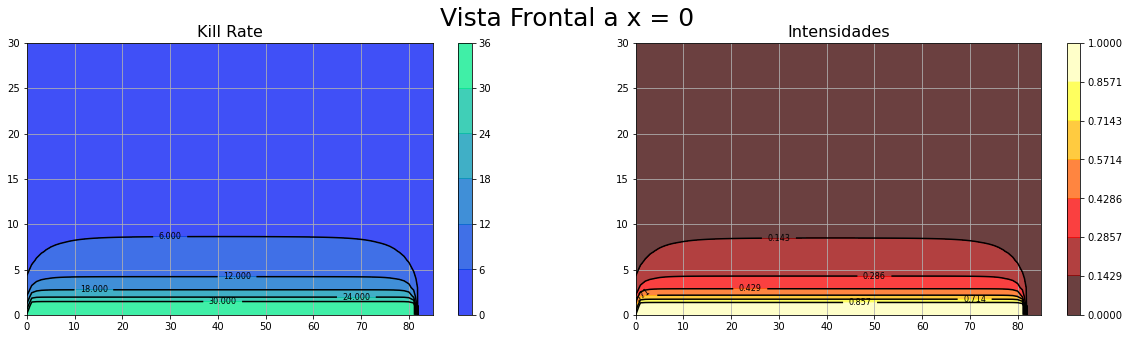

In [90]:
#Para explorar los resultados, es conveniente recuperar el vector de datos DirectField para
#cada plano de intersección
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

  
#Vista Frontal
#En la vista frontal X es un valor constante
#Z ocupa el valor de x y Y continúa siendo y
print('Plano Frontal, Corte en X: ')
planox=int(input()) # Corte en el medio

Z=[] #Los  valores recuperados en orden
Z1=[]  #DirectField
for n in range(len(coord)):
    i,j,k = coord[n]
    if (i==planox):
        Z.append(RateKill[n])
        Z1.append(DirectField1[n])  
        
Z22=Z1     

levels = np.linspace(min(Z22),max(Z22),8)        
        
X=np.arange(0,zend+1,1)
Y=np.arange(0,yend+1,1)
Z=np.reshape(Z,(yend+1,zend+1))
Z1=np.reshape(Z1,(yend+1,zend+1))

a=plt.figure(figsize=(20,5))
a.suptitle('Vista Frontal a x = '+str(planox), fontsize=25)
plt.subplot(1,2,1)
h = plt.contourf(X,Y,Z, 5, alpha=.75, cmap=plt.cm.winter)
plt.colorbar()
contours = plt.contour(X, Y, Z, 5, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.title('Kill Rate',fontsize=16)
plt.grid()

plt.subplot(1,2,2)
h = plt.contourf(X,Y,Z1, levels, alpha=.75, cmap=plt.cm.hot)
plt.colorbar()
contours = plt.contour(X, Y, Z1, levels, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.title('Intensidades',fontsize=16)
plt.grid()

Plano Lateral, Corte en Z: 
42


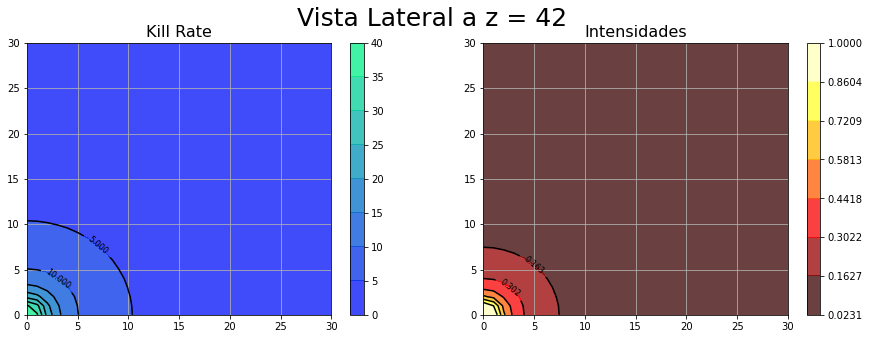

In [91]:
#Para una vista lateral Z es un plano constante
#el valor x e y siguen siendo iguales
print('Plano Lateral, Corte en Z: ')
planoz=int(input()) # Corte en el medio

Z=[]
Z1=[]

for n in range(len(coord)):
    i,j,k = coord[n]
    if (k==planoz):
        Z.append(RateKill[n])
        Z1.append(DirectField1[n])
        
Z22=Z1     

levels = np.linspace(min(Z22),max(Z22),8)        
        
X=np.arange(0,xend+1,1)
Y=np.arange(0,yend+1,1)
Z=np.reshape(Z,(xend+1,yend+1))
Z1=np.reshape(Z1,(xend+1,yend+1))

a=plt.figure(figsize=(15,5))
a.suptitle('Vista Lateral a z = '+str(planoz), fontsize=25)

plt.subplot(1,2,1)
h = plt.contourf(X,Y,Z, 7, alpha=.75, cmap=plt.cm.winter)
plt.colorbar()
contours = plt.contour(X, Y, Z,7, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.title('Kill Rate',fontsize=16)
plt.grid()


plt.subplot(1,2,2)
h = plt.contourf(X,Y,Z1,levels, alpha=.75, cmap=plt.cm.hot)
plt.colorbar()
contours = plt.contour(X, Y, Z1, levels, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.title('Intensidades',fontsize=16)
plt.grid()


Plano Superior, Corte en Y: 
0


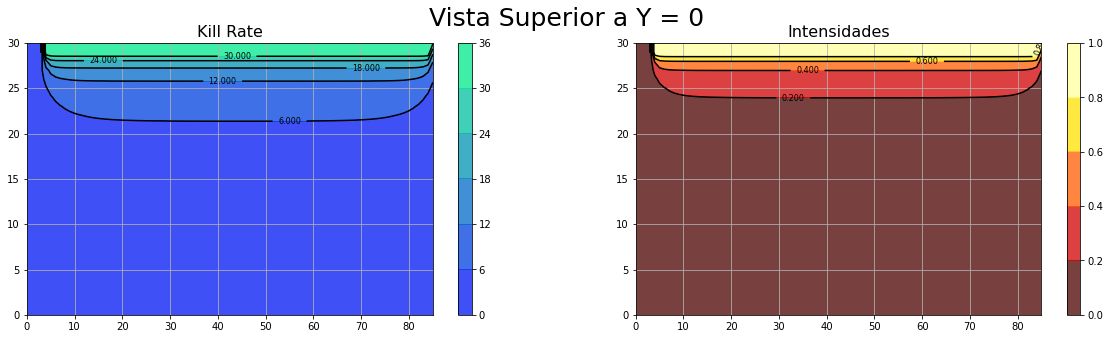

In [95]:
#Para una vista Superior, Y es un plano constante
#x es z 
#y es x



print('Plano Superior, Corte en Y: ')
planoy=int(input()) # Corte en el medio

Z=[]
Z1=[]

for n in range(len(coord)):
    i,j,k = coord[n]
    if (j==planoy):
        Z.append(RateKill[n])
        Z1.append(DirectField1[n])
Z22=Z1     

levels = np.linspace(min(Z22),max(Z22),6)

X=np.arange(0,zend+1,1)
Y=np.arange(0,xend+1,1)
Z=np.reshape(Z[::-1],(xend+1,zend+1))
Z1=np.reshape(Z1[::-1],(xend+1,zend+1))



a=plt.figure(figsize=(20,5))
a.suptitle('Vista Superior a Y = '+str(planoy), fontsize=25)

plt.subplot(1,2,1)
h = plt.contourf(X,Y,Z, 5, alpha=.75, cmap=plt.cm.winter)
plt.colorbar()
contours = plt.contour(X, Y, Z,5, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.title('Kill Rate',fontsize=16)
plt.grid()


plt.subplot(1,2,2)
h = plt.contourf(X,Y,Z1, levels, alpha=.75, cmap=plt.cm.hot)
plt.colorbar()
contours = plt.contour(X, Y, Z1, levels, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.title('Intensidades',fontsize=16)
plt.grid()


In [57]:
min(Z22)

1.1102221070862245e-16